# Run memento for inference comparison

Power analysis for DM, DV, and DC

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix


/tmp/ipykernel_15828/1472718865.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [71]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [72]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [73]:
data_path = '/data_volume/memento/simulation/inference/'

### Run memento for DE

In [74]:
de_sim_adata = sc.read(data_path + 'de.h5ad')
de_sim_adata.obs['q'] = 0.07

memento.setup_memento(de_sim_adata, q_column='q', filter_mean_thresh=0.0001,trim_percent=1, shrinkage=0)
de_sim_adata.obs['memento_size_factor'] = de_sim_adata.X.sum(axis=1).A1
memento.create_groups(de_sim_adata, label_columns=['ct_real'])
memento.compute_1d_moments(de_sim_adata, filter_genes=True)

meta_df = memento.get_groups(de_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['A']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

memento.ht_1d_moments(
    de_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=50000, 
    verbose=1,
    num_cpus=40,
    resampling='bootstrap',
    approx=False)

memento_de_result = memento.get_1d_ht_result(de_sim_adata)
memento_de_result.to_csv(data_path + 'memento_de.csv', index=False)
de_sim_adata.write(data_path + 'de_filtered.h5ad')
de_sim_norm_adata = de_sim_adata.copy().copy()
sc.pp.normalize_total(de_sim_norm_adata)
sc.pp.log1p(de_sim_norm_adata)
sc.pp.scale(de_sim_norm_adata)
de_sim_norm_adata.write(data_path + 'de_filtered_norm.h5ad')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.4s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   12.6s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   18.2s
[Parallel(n_jobs=40)]: Done 1170 tasks      | elapsed:   25.2s
[Parallel(n_jobs=40)]: Done 1720 tasks      | elapsed:   33.9s
[Parallel(n_jobs=40)]: Done 2370 tasks      | elapsed:   43.8s
[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:   55.5s
[Parallel(n_jobs=40)]: Done 3970 tasks      | elapsed:  1.1min
[Parallel(n_jobs=40)]: Done 4920 tasks      | elapsed:  1.4min
[Parallel(n_jobs=40)]: Done 5970 tasks      | elapsed:  1.7min

In [ ]:
def get_bootstrap_dist(group, col):
    
    data = de_sim_adata[de_sim_adata.obs.ct_real == group].X[:, col].todense().A1.astype(int)
    counts = np.bincount(data)
    N = counts.sum()
    freq = counts/N
    multi_resampled_means = (stats.multinomial.rvs(N, freq, size=10000)*np.arange(counts.shape[0])).sum(axis=1)/N
    return data, multi_resampled_means

In [ ]:
dA, A = get_bootstrap_dist('A', 3)
dB, B = get_bootstrap_dist('B', 3)

In [ ]:
stats.ttest_ind(dA, dB)

In [ ]:
sns.kdeplot(A-B)

In [15]:
np.bincount(de_sim_adata[de_sim_adata.obs.ct_real == 'B'].X[:, 0].todense().A1.astype(int))

array([863, 117,  17,   3])

In [42]:
data = de_sim_adata[de_sim_adata.obs.ct_real == 'B'].X[:, 0].todense().A1.astype(int)
counts = np.bincount(data)
N = counts.sum()
freq = counts/N

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [43]:
np.random.choice(5, replace=True, size=10)

array([2, 2, 4, 2, 1, 3, 1, 2, 0, 4])

In [50]:
multi_resampled_means_B = (stats.multinomial.rvs(N, freq, size=10000)*np.arange(counts.shape[0])).sum(axis=1)/N


<AxesSubplot:ylabel='Density'>

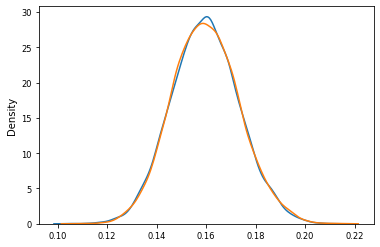

In [52]:
sns.kdeplot(multi_resampled_means)
sns.kdeplot(actual_means)

In [67]:
de_sim_adata = sc.read(data_path + 'de.h5ad')
de_sim_adata.obs['q'] = 0.07

memento.setup_memento(de_sim_adata, q_column='q', filter_mean_thresh=0.005,trim_percent=1, shrinkage=0)
de_sim_adata.obs['memento_size_factor'] = de_sim_adata.X.sum(axis=1).A1
memento.create_groups(de_sim_adata, label_columns=['ct_shuffled'])
memento.compute_1d_moments(de_sim_adata, filter_genes=True)

meta_df = memento.get_groups(de_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['A']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

memento.ht_1d_moments(
    de_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=5000, 
    verbose=1,
    num_cpus=13,
    resampling='bootstrap',
    approx=False)

memento_de_result = memento.get_1d_ht_result(de_sim_adata)
memento_de_result.to_csv(data_path + 'memento_de_shuffled.csv', index=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:    4.3s
[Parallel(n_jobs=13)]: Done 1522 tasks      | elapsed:    8.0s
[Parallel(n_jobs=13)]: Done 2422 tasks      | elapsed:   12.7s
[Parallel(n_jobs=13)]: Done 3522 tasks      | elapsed:   18.5s
[Parallel(n_jobs=13)]: Done 4822 tasks      | elapsed:   25.2s
[Parallel(n_jobs=13)]: Done 6322 tasks      | elapsed:   33.2s
[Parallel(n_jobs=13)]: Done 7343 out of 7368 | elapsed:   38.5s remaining:    0.1s
[Parallel(n_jobs=13)]: Done 7368 out of 73

### Run memento for DV

In [31]:
dv_sim_adata = sc.read(data_path + 'dv.h5ad')
dv_sim_adata.obs['q'] = 0.07

memento.setup_memento(dv_sim_adata, q_column='q', filter_mean_thresh=0.07,trim_percent=1, shrinkage=0)
memento.create_groups(dv_sim_adata, label_columns=['ct_real'])
memento.compute_1d_moments(dv_sim_adata, filter_genes=True)

meta_df = memento.get_groups(dv_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['A']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

memento.ht_1d_moments(
    dv_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=5000, 
    verbose=1,
    num_cpus=13,
    resampling='bootstrap',
    approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.6s

KeyboardInterrupt



In [ ]:
memento_dv_result = memento.get_1d_ht_result(dv_sim_adata)
memento_dv_result['gene'] = memento_dv_result['gene'].astype(int)

In [ ]:
(memento_dv_result.query('gene < 500').dv_pval < 0.05).mean()

In [ ]:
memento_dv_result.to_csv(data_path + 'memento_dv.csv', index=False)
dv_sim_adata.write(data_path + 'dv_filtered.h5ad')

### Run memento for DC

In [12]:
len(candidate_pairs)

1225

In [13]:
dc_sim_adata = sc.read(data_path + 'dc.h5ad')
dc_sim_adata.obs['q'] = 0.07

memento.setup_memento(dc_sim_adata, q_column='q', filter_mean_thresh=0.07,trim_percent=1, shrinkage=0)
memento.create_groups(dc_sim_adata, label_columns=['ct_real'])
memento.compute_1d_moments(dc_sim_adata, filter_genes=True)
candidate_pairs = list(itertools.combinations(np.arange(100).astype(str),2))
pairs = [(a,b) for a,b in candidate_pairs if a in dc_sim_adata.var.index and b in dc_sim_adata.var.index]
memento.compute_2d_moments(dc_sim_adata, gene_pairs=pairs)


meta_df = memento.get_groups(dc_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['A']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

memento.ht_2d_moments(
    dc_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=5000, 
    verbose=1,
    num_cpus=13,
    resampling='bootstrap',
    approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=13)]: Done 105 out of 105 | elapsed:    9.6s finished


In [16]:
memento_dc_result = memento.get_2d_ht_result(dc_sim_adata)

In [ ]:
memento_dc_result.to_csv(data_path + 'memento_dc.csv', index=False)
dc_sim_adata.write(data_path + 'dc_filtered.h5ad')